In [1]:
import os
os.environ["JULIA_NUM_THREADS"] = "8" 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from distfit import distfit
import re
from sympy import symbols, simplify, sin, cos, log, Abs, exp, expand_power_base, Mul, Rational, sqrt
from sympy.parsing.sympy_parser import parse_expr
import seaborn as sns
import copy
import json
from ydata_profiling import ProfileReport
import sys
from pysr import PySRRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel

# Add the directory containing 'thesis_utils.py' to the system path
sys.path.append(os.path.abspath('..'))  # If 'thesis_utils.py' is one level up
# Or use this if it's in the same directory as the notebook:
# sys.path.append(os.getcwd())

from thesis_utils import *

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [251]:
import importlib
import thesis_utils  # or whatever your module is called

importlib.reload(thesis_utils)

from thesis_utils import *

In [2]:
data = pd.read_csv("C:/Users/svenl/vs_code_projects/hyperRealDataDescriber/data/credit_score/cleaned_credit_score_v2.csv")
data_sample = data.sample(n=9600)

In [3]:
X = data_sample[['Credit_History_Age', 'Delay_from_due_date', 'Num_Bank_Accounts', 'Num_Credit_Inquiries', 'Num_of_Delayed_Payment', 'Outstanding_Debt']].to_numpy()
y = data_sample['Interest_Rate'].to_numpy()

10.7**2 * RBF(length_scale=30) + WhiteKernel(noise_level=25.8)


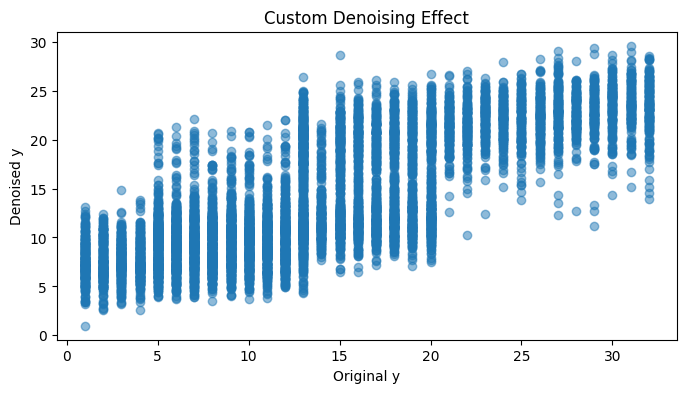

In [94]:
kernel = (ConstantKernel(1.0) * 
          RBF(length_scale=0.1, length_scale_bounds=(1e-3, 30)) +
          WhiteKernel(noise_level=1.0, noise_level_bounds=(1e-5, 1e3)))

gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-10, n_restarts_optimizer=1)
gp.fit(X, y)
print(gp.kernel_)
y_denoised_fixed = gp.predict(X)

# Optionally, you can visualize the effect of denoising:
plt.figure(figsize=(8,4))
plt.scatter(y, y_denoised_fixed, alpha=0.5)
plt.xlabel("Original y")
plt.ylabel("Denoised y")
plt.title("Custom Denoising Effect")
plt.show()

In [ ]:
model = PySRRegressor(niterations=256, denoise=False, progress=True, maxsize=50)
model.fit(X, y_denoised_fixed)
print("Discovered symbolic regression model:")
print(model)

[ Info: Started!


In [4]:
candidate_function = generate_candidate_function("(((x2 + x3) / 2.566063) + (sqrt(x4) + ((x1 * 6.5023026) / (x0 + x1)))) - (x5 * -0.001546992)")

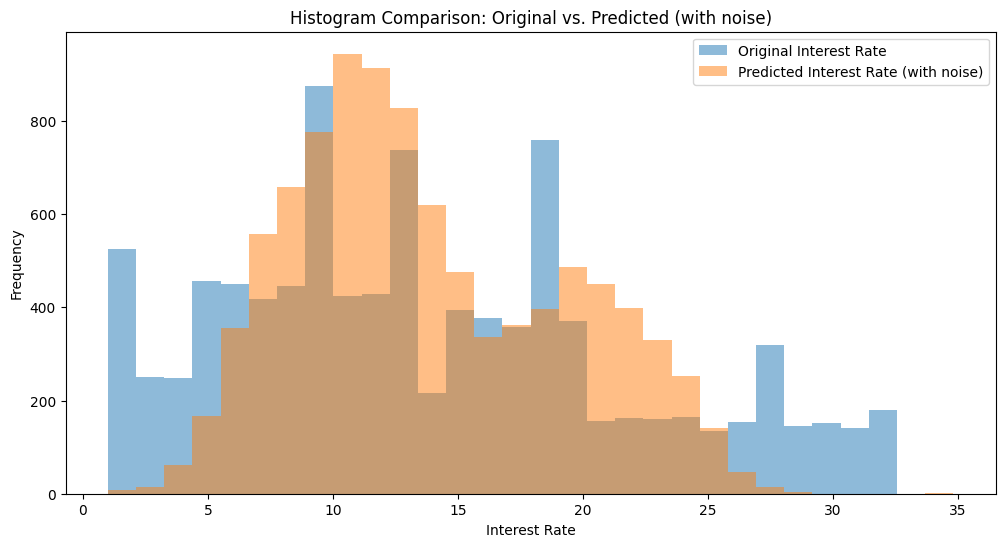

In [5]:
y_denoised = candidate_function(X)
bins = np.histogram_bin_edges(np.concatenate([y, y_denoised]), bins=30)
plt.figure(figsize=(12, 6))
plt.hist(y, bins=bins, alpha=0.5, label="Original Interest Rate")
plt.hist(y_denoised, bins=bins, alpha=0.5, label="Predicted Interest Rate (with noise)")
plt.xlabel("Interest Rate")
plt.ylabel("Frequency")
plt.title("Histogram Comparison: Original vs. Predicted (with noise)")
plt.legend()
plt.show()

In [204]:
# X_selected = X[:, [0, 1, 4, 5]]
y_denoised = candidate_function(X)

In [6]:
y_pred_final, best_amp, errors = renoise_predictions(y, y_denoised, method='bootstrap')

In [7]:
data_sample = data_sample.reset_index()

In [141]:
y_pred_xgboost = correct_sr_inference(data_sample, ['Credit_History_Age', 'Delay_from_due_date', 'Num_Bank_Accounts', 'Num_Credit_Inquiries', 'Num_of_Delayed_Payment', 'Outstanding_Debt'], 'Interest_Rate', pd.Series(y_denoised))

XGBoost Residual Correction Test MSE: 26.9064
Final MSE after XGBoost residual correction: 5.3907


In [192]:
residuals = y - y_denoised

In [233]:
# 1) Your denoised prediction & residuals
y_denoised = candidate_function(X)
residuals = y - y_denoised

# 2) Bin edges & indices
n_bins = 5
edges = np.quantile(y_denoised, np.linspace(0, 1, n_bins + 1))
bin_idx = np.digitize(y_denoised, edges[1:-1])  # 0..n_bins-1 guaranteed

# 3) Group residuals by bin
residuals_by_bin = {
    b: residuals[bin_idx == b]
    for b in range(n_bins)
}

# 4) Sample residuals stratified by bin (with a global fallback)
np.random.seed(42)
bootstrap_noise = np.empty_like(y_denoised)
for i in range(len(y_denoised)):
    pool = residuals_by_bin.get(bin_idx[i])
    if pool is None or pool.size == 0:
        pool = residuals
    bootstrap_noise[i] = np.random.choice(pool)

# 5) Final prediction (and optional clipping at zero)
y_pred = y_denoised + bootstrap_noise
y_pred = np.maximum(y_pred, 0)  # if you want no negatives

In [223]:
y_pred = y_denoised + bootstrap_noise

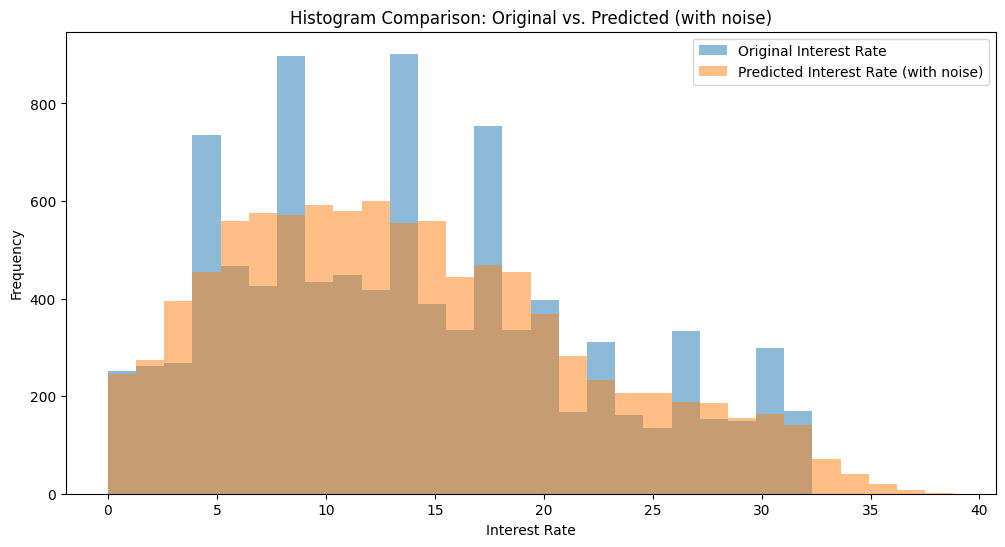

In [234]:
bins = np.histogram_bin_edges(np.concatenate([y, y_pred]), bins=30)
plt.figure(figsize=(12, 6))
plt.hist(y, bins=bins, alpha=0.5, label="Original Interest Rate")
plt.hist(y_pred, bins=bins, alpha=0.5, label="Predicted Interest Rate (with noise)")
plt.xlabel("Interest Rate")
plt.ylabel("Frequency")
plt.title("Histogram Comparison: Original vs. Predicted (with noise)")
plt.legend()
plt.show()

In [9]:
X_total = data[['Credit_History_Age', 'Delay_from_due_date', 'Num_Bank_Accounts', 'Num_Credit_Inquiries', 'Num_of_Delayed_Payment', 'Outstanding_Debt']].to_numpy()
y_total = data['Interest_Rate'].to_numpy()

In [11]:
y_denoised_total = candidate_function(X_total)

In [248]:
residuals = y_total - y_denoised_total

# 2) Bin edges & indices
n_bins = 5
edges = np.quantile(y_denoised_total, np.linspace(0, 1, n_bins + 1))
bin_idx = np.digitize(y_denoised_total, edges[1:-1])  # 0..n_bins-1 guaranteed

# 3) Group residuals by bin
residuals_by_bin = {
    b: residuals[bin_idx == b]
    for b in range(n_bins)
}

# 4) Sample residuals stratified by bin (with a global fallback)
np.random.seed(42)
bootstrap_noise = np.empty_like(y_denoised_total)
for i in range(len(y_denoised_total)):
    pool = residuals_by_bin.get(bin_idx[i])
    if pool is None or pool.size == 0:
        pool = residuals
    bootstrap_noise[i] = np.random.choice(pool)

# 5) Final prediction (and optional clipping at zero)
y_pred_total = y_denoised_total + bootstrap_noise
y_pred_total = np.maximum(y_pred_total, 0)  # if you want no negatives

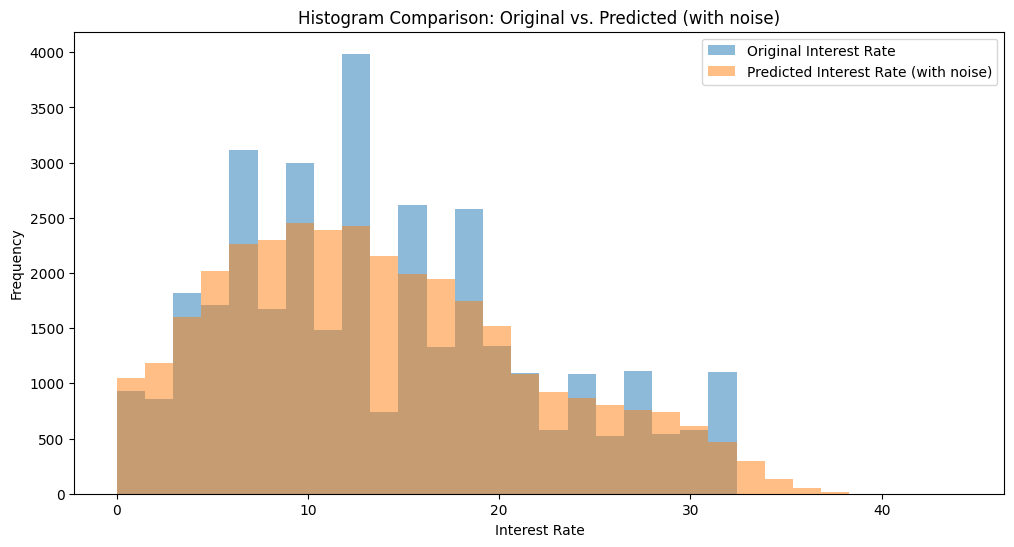

In [249]:
bins = np.histogram_bin_edges(np.concatenate([y_total, y_pred_total]), bins=30)
plt.figure(figsize=(12, 6))
plt.hist(y_total, bins=bins, alpha=0.5, label="Original Interest Rate")
plt.hist(y_pred_total, bins=bins, alpha=0.5, label="Predicted Interest Rate (with noise)")
plt.xlabel("Interest Rate")
plt.ylabel("Frequency")
plt.title("Histogram Comparison: Original vs. Predicted (with noise)")
plt.legend()
plt.show()

In [12]:
y_renoised, best_amp, errors = renoise_predictions(y_total, y_denoised_total, method='stratified', seed=42)

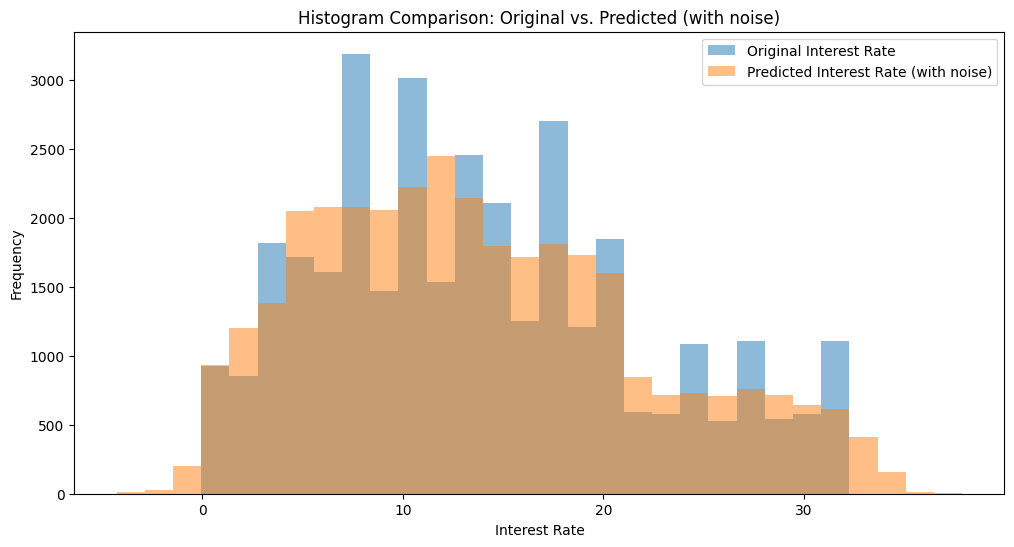

In [13]:
bins = np.histogram_bin_edges(np.concatenate([y_total, y_renoised]), bins=30)
plt.figure(figsize=(12, 6))
plt.hist(y_total, bins=bins, alpha=0.5, label="Original Interest Rate")
plt.hist(y_renoised, bins=bins, alpha=0.5, label="Predicted Interest Rate (with noise)")
plt.xlabel("Interest Rate")
plt.ylabel("Frequency")
plt.title("Histogram Comparison: Original vs. Predicted (with noise)")
plt.legend()
plt.show()